In [1]:
import numpy as np
from scipy.special import lambertw

def scaled_response(t, tc, C, F, l, l1, l2, h, w, N0, D, ka, kd):
    """
    Reponse normalized (between 0 and 1) by the theoretical max. response. To get SPR response,
    multiply by Rmax. To get surface density, multiply by N0.

    Based on L. L. H. Christensen, “Theoretical Analysis of Protein Concentration Determination Using 
    Biosensor Technology under Conditions of Partial Mass Transport Limitation,” Analytical Biochemistry, 
    vol. 249, no. 2, pp. 153–164, Jul. 1997, doi: 10.1006/abio.1997.2182.

    Inputs:
        t: numpy array of time values in seconds
        tc: cutoff time between association and dissociation, s
        C: bulk concentration of analyte, M
        F: flow rate, cm^3/s
        l: cell length, cm
        l1: length to the start of the detection area from the inlet of the flow cell, cm
        l2: length to the end of the detection area from the inlet of the flow cell, cm
        h: cell height, cm
        w: cell width, cm
        N0: total amount of ligand on the surface (i.e., available binding sites) at time 0, #/cm^2
        D: diffusion constant, cm^2/s
        ka: association constant, M^-1 s^-1
        kd: dissociation constant, s^-1
    """

    ta = t[t <= tc]
    td = t[t > tc]

    Ckc = 1.47 * (1 - ((l1 / l2) ** (2/3))) / (1 - l1 / l2)     # unitless
    kc = Ckc * ((D**2) * F / (h**2 * w * l2)) ** (1/3)          # cm/s

    alpha = kc * C / (kd * N0)
    beta = kc / (ka * N0)

    # association
    K1 = alpha / (alpha + beta)
    K2 = alpha / (beta * (1 + alpha + beta))
    K3 = ((alpha + beta) ** 2) / (beta * (1 + alpha + beta))
    Rta = np.real(K1 * (1 - (1 / K2) * lambertw(K2 * np.exp(K2 - K3 * kd * ta))))

    # dissociation
    Rtc = np.real(Rta[-1])
    Rtd = np.real(-(beta + 1) * lambertw(-Rtc * np.exp(-(beta * kd * (td - tc) + Rtc) / (beta + 1)) / (beta + 1)))

    return np.concatenate((Rta, Rtd))

Text(0.5, 1.0, 'Noiseless Simulated Response: Partial Mass Transport Model')

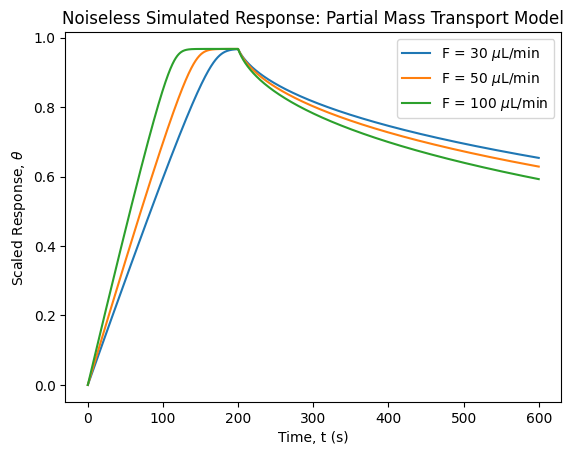

In [2]:
import matplotlib.pyplot as plt

for i, F in enumerate(np.array([30, 50, 100]) * 1e-3 / 60):

    # from original paper
    l = 0.24 # cm
    l1 = 0.03 # cm
    l2 = 0.2 # cm
    h = 0.005 # cm
    w = 0.05 # cm
    C = 10e-9  # M
    D = 9.09e-7 # cm^2/s
    ka = 6e7 # M^-1 s^-1
    kd = 0.02 # s^-1

    # Based on biacoreT2000.py, with S and molec_mass changed to match the original paper.
    # Probably not the correct value, but works well for this particular simulation.
    # The true value is probably in the same order.
    NA = 6.02214e23  # Avodgadro's number
    molec_mass = 35  # kDa
    S = l * w  # cm^2
    ImmobilizationRU = 1000 / 1e12 / 1.66033e-27 / 1000
    N0 = (ImmobilizationRU / molec_mass / NA * 1e9) / S * 1e-9

    tc = 200
    t = np.linspace(0, 3 * tc, 10 * tc)

    Rt = scaled_response(t, tc, C, F, l, l1, l2, h, w, N0, D, ka, kd)
    label = f'F = {int(F * 60e3)} $\mu$L/min'
    plt.plot(t, Rt, label=label)

plt.legend()
plt.xlabel('Time, t (s)')
plt.ylabel('Scaled Response, $\\theta$')
plt.title('Noiseless Simulated Response: Partial Mass Transport Model')

Text(0.5, 1.0, 'Noiseless Simulated Response: Partial Mass Transport Model')

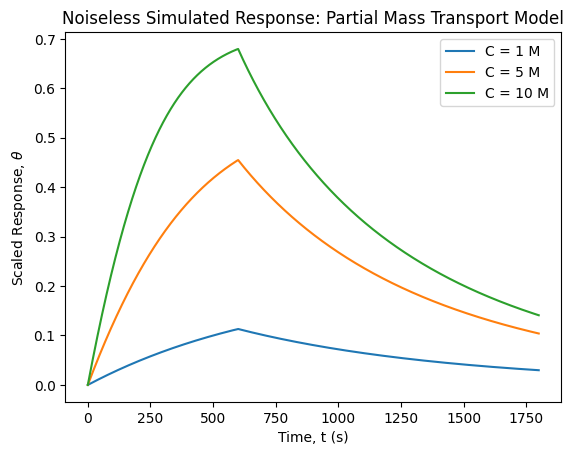

In [3]:
import matplotlib.pyplot as plt

for i, C in enumerate(np.array([1, 5, 10]) * 1e-9):

    # based on histones experiments
    l = 0.24 # cm
    h = 0.004 # cm
    w = 0.05 # cm
    F = 30e-3 / 60 # cm^3/s
    ka = 5.62e5 # M^-1 s^-1
    kd = 2.25e-3 # s^-1

    # from original paper
    l1 = 0.03 # cm
    l2 = 0.2 # cm

    # Based on biacoreT2000.py, with S and molec_mass changed to match the original paper.
    # Probably not the correct value, but works well for this particular simulation.
    # The true value is probably in the same order.
    NA = 6.02214e23  # Avodgadro's number
    molec_mass = 11  # kDa
    S = l * w  # cm^2
    ImmobilizationRU = 1000 / 1e12 / 1.66033e-27 / 1000
    N0 = (ImmobilizationRU / molec_mass / NA * 1e9) / S * 1e-10
    molec_length = 103  # estimated in nm
    R = 8.31446261815324  # Gas Constant in SI units
    T = 293  # standard room temperature in Kelvin
    eta = 10e-3  # Viscosity of water at room temperature in Pa*s
    D = 0.1e-6

    tc = 600
    t = np.linspace(0, 3 * tc, 10 * tc)

    Rt = scaled_response(t, tc, C, F, l, l1, l2, h, w, N0, D, ka, kd)
    label = f'C = {int(C * 1e9)} M'
    plt.plot(t, Rt, label=label)

plt.legend()
plt.xlabel('Time, t (s)')
plt.ylabel('Scaled Response, $\\theta$')
plt.title('Noiseless Simulated Response: Partial Mass Transport Model')